In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
# ----設定繪圖-------
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft Dexter'] 
plt.rcParams['axes.unicode_minus'] = False  
from matplotlib.font_manager import FontProperties 
import seaborn as sns 
myfont=FontProperties(fname='Microsoft JhengHei',size=14) 
sns.set(font=myfont.get_family()) 
sns.set_style("darkgrid",{"font.sans-serif":['Microsoft Dexter']}) 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = None
#------時間------
from datetime import datetime,timedelta
from datetime import datetime as dt
import time

from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,cross_validate
from sklearn.externals import joblib
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import accuracy_score,f1_score,r2_score,recall_score,roc_auc_score,precision_recall_curve,roc_curve,auc
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
import scikitplot as skplt
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE

In [2]:
def gini(arr):
    ## first sort
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

def lorenz_curve(X):
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0) 
    X_lorenz[0], X_lorenz[-1]
    fig, ax = plt.subplots(figsize=[6,6])
    ## scatter plot of Lorenz curve
    ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, 
               marker='x', color='darkgreen', s=100)
    ## line plot of equality
    ax.plot([0,1], [0,1], color='k')
    
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):

    df.sort_values(by=probability_col, ascending=False, inplace=True)

    subset = df[df[predicted_col] == True]

    rows = []
    for group in np.array_split(subset, 10):
        score = sklearn.metrics.accuracy_score(group[actual_col].tolist(),
                                                   group[predicted_col].tolist(),
                                                   normalize=False)

        rows.append({'NumCases': len(group), 'NumCorrectPredictions': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['RunningCorrect'] = lift['NumCorrectPredictions'].cumsum()
    lift['PercentCorrect'] = lift.apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x['RunningCorrect'], axis=1)
    lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
    lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(
        lambda x: 100 if (100 / lift['NumCorrectPredictions'].sum()) * x > 100 else (100 / lift[
            'NumCorrectPredictions'].sum()) * x)
    lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
    lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x)

    #Lift Chart
    lift['NormalisedPercentAvg'] = 1
    lift['NormalisedPercentWithModel'] = lift['PercentCorrect'] / lift['PercentAvgCase']

    return lift

def plot_cumulative_gains(lift: pd.DataFrame):
    fig, ax = plt.subplots()
    fig.canvas.draw()

    handles = []
    handles.append(ax.plot(lift['PercentCorrect'], 'r-', label='Percent Correct Predictions'))
    handles.append(ax.plot(lift['PercentCorrectBestCase'], 'g-', label='Best Case (for current model)'))
    handles.append(ax.plot(lift['PercentAvgCase'], 'b-', label='Average Case (for current model)'))
    ax.set_xlabel('Total Population (%)')
    ax.set_ylabel('Number of Respondents (%)')

    ax.set_xlim([0, 9])
    ax.set_ylim([10, 100])

    labels = [int((label+1)*10) for label in [float(item.get_text()) for item in ax.get_xticklabels()]]

    ax.set_xticklabels(labels)

    fig.legend(handles, labels=[h[0].get_label() for h in handles])
    fig.show()
    
def plot_lift_chart(lift: pd.DataFrame):
        plt.figure()
        plt.plot(lift['NormalisedPercentAvg'], 'r-', label='Normalised \'response rate\' with no model')
        plt.plot(lift['NormalisedPercentWithModel'], 'g-', label='Normalised \'response rate\' with using model')
        plt.legend()
        plt.show()

In [3]:
df_head = pd.read_csv('D:/karma5.0/0121/head.csv')
df = pd.read_csv('D:/karma5.0/0212/K5datasets41to60.csv',names=df_head.columns.tolist())
print('-'*10,'Data Sets information','-'*10)
print('datasets raw counts',df.shape[0])
print('datasets column counts',df.shape[1])


L11=[]
L22=list(df.isnull().sum()/len(df))
for i in df:
    #print('column name','kinds counts')
    L11.append((i,len(df[str(i)].value_counts())))
print('-'*10,'Check 1-value-variable column','-'*10)
df0 = pd.DataFrame(L11,columns=['column_name','species_counts'])
print(df0[df0['species_counts']==1])
print('-'*10,'Check 1-value-variable value and counts','-'*10)
for i in df0['column_name'][df0['species_counts']==1]:
    print(df[str(i)].value_counts())

---------- Data Sets information ----------
datasets raw counts 387198
datasets column counts 444
---------- Check 1-value-variable column ----------
        column_name  species_counts
404    L14D_conMCNT               1
435  WarrantyPeriod               1
---------- Check 1-value-variable value and counts ----------
0.0    343531
Name: L14D_conMCNT, dtype: int64
7    387198
Name: WarrantyPeriod, dtype: int64


In [4]:
df_data = df[['DDwFD', 'contractsn', 'DATE', 'DuringMBA', 'RH', 'AH', 're', 'fbCNT',
       'nCR', 'nMR', 'nTR', 'nconcompla', 'nconcompli', 'nmatcompla',
       'nmatcompli', 'nteccompla', 'accLIKE', 'proLIKE', 'accDLIKE',
       'proDLIKE', 'FavorCNT', 'BlockCNT', 'AddFavorCNT', 'AddBlockCNT',
       'star', 'isIntCNT', 'LVdiffCNT', 'MGMLead', 'MGMRes', 'MGMDemo',
       'MGMDeal', 'conUUCCNT', 'conSOUCNT', 'conSERCNT', 'conTWBCNT',
       'conOTHCNT', 'conLigCNT', 'conMedCNT', 'conTanCNT', 'conDarCNT',
       'conEx01CNT', 'conEx03CNT', 'conEx12CNT', 'conEx24CNT', 'conage30CNT',
       'conage40CNT', 'conage50CNT', 'conage60CNT', 'conage61CNT', 'conMCNT',
       'conFCNT', 'helpCNT', 'helpCNTmax', 'help3mCNT', 'help3mCNTmax',
       'helpITCNT', 'helpITCNTmax', 'helpIT3mCNT', 'helpIT3mCNTmax',
       'helpIiCNT', 'helpIiCNTmax', 'helpIi3mCNT', 'helpIi3mCNTmax',
       'helpMaCNT', 'helpMaCNTmax', 'helpMa3mCNT', 'helpMa3mCNTmax',
       'helpTeCNT', 'helpTeCNTmax', 'helpTe3mCNT', 'helpTe3mCNTmax',
       'helpconCNT', 'helpconCNTmax', 'helpcon3mCNT', 'helpcon3mCNTmax',
       'ALL_RH', 'ALL_AH', 'ALL_re', 'ALL_fbCNT', 'ALL_nCR', 'ALL_nMR',
       'ALL_nTR', 'ALL_nconcompla', 'ALL_nconcompli', 'ALL_nmatcompla',
       'ALL_nmatcompli', 'ALL_nteccompla', 'ALL_accLIKE', 'ALL_proLIKE',
       'ALL_accDLIKE', 'ALL_proDLIKE', 'ALL_FavorCNT', 'ALL_BlockCNT',
       'ALL_AddFavorCNT', 'ALL_AddBlockCNT', 'ALL_star', 'ALL_isIntCNT',
       'ALL_LVdiffCNT', 'ALL_MGMLead', 'ALL_MGMRes', 'ALL_MGMDemo',
       'ALL_MGMDeal', 'ALL_conUUCCNT', 'ALL_conSOUCNT', 'ALL_conSERCNT',
       'ALL_conTWBCNT', 'ALL_conOTHCNT', 'ALL_conLigCNT', 'ALL_conMedCNT',
       'ALL_conTanCNT', 'ALL_conDarCNT', 'ALL_conEx01CNT', 'ALL_conEx03CNT',
       'ALL_conEx12CNT', 'ALL_conEx24CNT', 'ALL_conage30CNT',
       'ALL_conage40CNT', 'ALL_conage50CNT', 'ALL_conage60CNT',
       'ALL_conage61CNT', 'ALL_conMCNT', 'ALL_conFCNT', 'ALL_helpCNT',
       'ALL_helpCNTmax', 'ALL_help3mCNT', 'ALL_help3mCNTmax', 'ALL_helpITCNT',
       'ALL_helpITCNTmax', 'ALL_helpIT3mCNT', 'ALL_helpIT3mCNTmax',
       'ALL_helpIiCNT', 'ALL_helpIiCNTmax', 'ALL_helpIi3mCNT',
       'ALL_helpIi3mCNTmax', 'ALL_helpMaCNT', 'ALL_helpMaCNTmax',
       'ALL_helpMa3mCNT', 'ALL_helpMa3mCNTmax', 'ALL_helpTeCNT',
       'ALL_helpTeCNTmax', 'ALL_helpTe3mCNT', 'ALL_helpTe3mCNTmax',
       'ALL_helpconCNT', 'ALL_helpconCNTmax', 'ALL_helpcon3mCNT',
       'ALL_helpcon3mCNTmax','FDsellingdate',
       'product_sdate', 'mb', 'mb_STV', 'mbdate', 'WarrantyPeriod', 'mbaCNT',
       'mbadate_First', 'mbadate_New', 'MBA_technical', 'MBA_customer',
       'MBA_Scheduling', 'MBA_Class', 'MBA_Service']]


df_data['MBA_technical'] = df_data['MBA_technical'].fillna(0)
df_data['MBA_customer'] = df_data['MBA_customer'].fillna(0)
df_data['MBA_Scheduling'] = df_data['MBA_Scheduling'].fillna(0)
df_data['MBA_Class'] = df_data['MBA_Class'].fillna(0)
df_data['MBA_Service'] = df_data['MBA_Service'].fillna(0)
df_data['MBA_total']=df_data['MBA_Class']+df_data['MBA_Scheduling']+df_data['MBA_Service']+df_data['MBA_customer']+df_data['MBA_technical']
df_data['mbadate_First']=pd.to_datetime(df_data['mbadate_First']).dt.date
df_data['mbadate_New']=pd.to_datetime(df_data['mbadate_New']).dt.date
df_data['FDsellingdate']=pd.to_datetime(df_data['FDsellingdate']).dt.date
df_data['mbdate']=pd.to_datetime(df_data['mbdate']).dt.date

df_data['mbadiff'] = df_data['mbadate_New']-df_data['mbadate_First']
df_data['mbtime'] = df_data['mbdate']-df_data['FDsellingdate']
df_data['mbaFtoSelltime'] = df_data['mbadate_First']-df_data['FDsellingdate']
df_data['mbaNtoSelltime'] = df_data['mbadate_New']-df_data['FDsellingdate']
df_data['mbFdiff'] = df_data['mbdate']-df_data['mbadate_First']
df_data['mbNdiff'] = df_data['mbdate']-df_data['mbadate_New']
df_data = df_data.drop(['MBA_technical','MBA_customer','MBA_Scheduling','MBA_Class','MBA_Service'],axis=1)
df_data = df_data.drop(['ALL_nconcompli','ALL_nmatcompli'],axis=1)
df_data = df_data.drop(['mbadate_First','mbadate_New','FDsellingdate'],axis=1)
df_data = df_data.drop(['WarrantyPeriod'],axis=1)
df_data = df_data.drop(['product_sdate'],axis=1)

df_data['mbadiff'] = (df_data['mbadiff'] / np.timedelta64(1, 'D')).astype(float)
df_data['mbaFtoSelltime'] = (df_data['mbaFtoSelltime'] / np.timedelta64(1, 'D')).astype(float)
df_data['mbaNtoSelltime'] = (df_data['mbaNtoSelltime'] / np.timedelta64(1, 'D')).astype(float)

df_data['RH'] = df_data['RH'].fillna(0)
df_data['AH'] = df_data['AH'].fillna(0)
df_data['re'] = df_data['re'].fillna(0)
df_data['fbCNT'] = df_data['fbCNT'].fillna(0)
df_data['nCR'] = df_data['nCR'].fillna(0)
df_data['nMR'] = df_data['nMR'].fillna(0)
df_data['nTR'] = df_data['nTR'].fillna(0)
#mean_nconcompla = df_data['nconcompla'].mean()
#mean_nmatcompla = df_data['nmatcompla'].mean()
#mean_nteccompla = df_data['nteccompla'].mean()
df_data['nconcompla'] = df_data['nconcompla'].fillna(0)
df_data['nmatcompla'] = df_data['nmatcompla'].fillna(0)
df_data['nteccompla'] = df_data['nteccompla'].fillna(0)
df_data['star'] = df_data['star'].fillna(1)
df_data = df_data[df_data['star']<=5.0]
df_data['ALL_star'] = df_data['ALL_star'].fillna(1)
df_data = df_data[df_data['ALL_star']<=10.0]
df_data['isIntCNT'] = df_data['isIntCNT'].fillna(0)
df_data['ALL_RH'] = df_data['ALL_RH'].fillna(0)
df_data['ALL_AH'] = df_data['ALL_AH'].fillna(0)
df_data['ALL_re'] = df_data['ALL_re'].fillna(0)
df_data['ALL_fbCNT'] = df_data['ALL_fbCNT'].fillna(0)
df_data['ALL_nCR'] = df_data['ALL_nCR'].fillna(1)
df_data['ALL_nMR'] = df_data['ALL_nMR'].fillna(1)
df_data['ALL_nTR'] = df_data['ALL_nTR'].fillna(1)
df_data['ALL_nconcompla'] = df_data['ALL_nconcompla'].fillna(1)
df_data['ALL_nmatcompla'] = df_data['ALL_nmatcompla'].fillna(1)
df_data['ALL_nteccompla'] = df_data['ALL_nteccompla'].fillna(1)
df_data['ALL_isIntCNT'] = df_data['ALL_isIntCNT'].fillna(0)
df_data['MGM_total'] = df_data['MGMLead']+df_data['MGMRes']+df_data['MGMDemo']+df_data['MGMDeal']
df_data['ALL_MGM_total']= df_data['ALL_MGMLead']+df_data['ALL_MGMRes']+df_data['ALL_MGMDemo']+df_data['ALL_MGMDeal']
df_data['Like_total'] = df_data['accLIKE']+df_data['proLIKE']
df_data['ALL_Like_total'] = df_data['ALL_accLIKE']+df_data['ALL_proLIKE']
df_data['DLike_total'] = df_data['accDLIKE']+df_data['proDLIKE']
df_data['ALL_DLike_total'] = df_data['ALL_accDLIKE']+df_data['ALL_proDLIKE']
df_data['help_total'] = df_data['helpITCNT']+df_data['helpIiCNT']+df_data['helpTeCNT']+df_data['helpMaCNT']+df_data['helpconCNT']
df_data['ALL_help_total'] = df_data['ALL_helpITCNT']+df_data['ALL_helpIiCNT']+df_data['ALL_helpTeCNT']+df_data['ALL_helpMaCNT']+df_data['ALL_helpconCNT']
df_data['help_max_total'] = df_data['helpITCNTmax']+df_data['helpIiCNTmax']+df_data['helpTeCNTmax']+df_data['helpMaCNTmax']+df_data['helpconCNTmax']
df_data['ALL_help_max_total'] = df_data['ALL_helpITCNTmax']+df_data['ALL_helpIiCNTmax']+df_data['ALL_helpTeCNTmax']+df_data['ALL_helpMaCNTmax']+df_data['ALL_helpconCNTmax']
df_data['3mhelp_max_total'] = df_data['helpIT3mCNTmax']+df_data['helpIi3mCNTmax']+df_data['helpTe3mCNTmax']+df_data['helpMa3mCNTmax']+df_data['helpcon3mCNTmax']
df_data['ALL3m_help_max_total'] = df_data['ALL_helpIT3mCNTmax']+df_data['ALL_helpIi3mCNTmax']+df_data['ALL_helpTe3mCNTmax']+df_data['ALL_helpMa3mCNTmax']+df_data['ALL_helpcon3mCNTmax']

df_data = df_data.fillna(0)
df_data['DATE']=pd.to_datetime(df_data['DATE']).dt.date
df_data = df_data[df_data['mbaFtoSelltime']>=0.0]
df_data = df_data[df_data['mbaNtoSelltime']>=0.0]
print(df_data.shape)


df_ML = df_data[['DuringMBA', 'RH', 'AH', 're', 'fbCNT',
       'nCR', 'nMR', 'nTR', 'nconcompla', 'nmatcompla','nteccompla', 
        'isIntCNT','ALL_RH', 'ALL_AH', 'ALL_re', 'ALL_fbCNT', 'ALL_nCR', 'ALL_nMR',
       'ALL_nTR', 'ALL_nconcompla', 'ALL_nmatcompla', 'ALL_nteccompla',
       'ALL_accLIKE', 'ALL_proLIKE', 'ALL_accDLIKE', 'ALL_proDLIKE',
       'ALL_FavorCNT', 'ALL_BlockCNT', 'ALL_AddFavorCNT', 'ALL_AddBlockCNT',
       'ALL_star', 'ALL_isIntCNT',
       'ALL_conUUCCNT','ALL_conSOUCNT', 'ALL_conSERCNT', 'ALL_conTWBCNT', 'ALL_conOTHCNT',
       'ALL_conLigCNT', 'ALL_conMedCNT', 'ALL_conTanCNT', 'ALL_conDarCNT',
       'ALL_conEx01CNT', 'ALL_conEx03CNT', 'ALL_conEx12CNT', 'ALL_conEx24CNT',
       'ALL_conage30CNT', 'ALL_conage40CNT', 'ALL_conage50CNT',
       'ALL_conage60CNT', 'ALL_conage61CNT', 'ALL_conMCNT', 'ALL_conFCNT',
       'ALL_helpCNT','ALL_help3mCNT',
       'mb', 'mb_STV', 'mbaCNT',
       'MBA_total', 'mbadiff','mbaFtoSelltime', 'mbaNtoSelltime',
       'ALL_MGM_total','ALL_Like_total', 'ALL_DLike_total','ALL_help_total', 'ALL_help_max_total','ALL3m_help_max_total']]

print(df_ML.shape)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

(386703, 167)
(386703, 67)


# Anomaly Detection - One Class SVM

In [111]:
y = df_ML['mb']
X = df_ML.drop(['mb'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=40)
te = TargetEncoder(cols=['DuringMBA', 'RH', 'AH', 're', 'fbCNT',
       'nCR', 'nMR', 'nTR', 'nconcompla', 'nmatcompla','nteccompla', 
        'isIntCNT','ALL_RH', 'ALL_AH', 'ALL_re', 'ALL_fbCNT', 'ALL_nCR', 'ALL_nMR',
       'ALL_nTR', 'ALL_nconcompla', 'ALL_nmatcompla', 'ALL_nteccompla',
       'ALL_accLIKE', 'ALL_proLIKE', 'ALL_accDLIKE', 'ALL_proDLIKE',
       'ALL_FavorCNT', 'ALL_BlockCNT', 'ALL_AddFavorCNT', 'ALL_AddBlockCNT',
       'ALL_star', 'ALL_isIntCNT',
       'ALL_conUUCCNT','ALL_conSOUCNT', 'ALL_conSERCNT', 'ALL_conTWBCNT', 'ALL_conOTHCNT',
       'ALL_conLigCNT', 'ALL_conMedCNT', 'ALL_conTanCNT', 'ALL_conDarCNT',
       'ALL_conEx01CNT', 'ALL_conEx03CNT', 'ALL_conEx12CNT', 'ALL_conEx24CNT',
       'ALL_conage30CNT', 'ALL_conage40CNT', 'ALL_conage50CNT',
       'ALL_conage60CNT', 'ALL_conage61CNT', 'ALL_conMCNT', 'ALL_conFCNT',
       'ALL_helpCNT','ALL_help3mCNT',
        'mb_STV', 'mbaCNT',
       'MBA_total', 'mbadiff','mbaFtoSelltime', 'mbaNtoSelltime',
       'ALL_MGM_total','ALL_Like_total', 'ALL_DLike_total','ALL_help_total', 'ALL_help_max_total','ALL3m_help_max_total']).fit(X,y)
X_train_te = te.transform(X_train)
X_test_te = te.transform(X_test)
X_te = te.transform(X)


# outlier data
X_outliers = df_ML[df_ML['mb']==1]
y_outliers = X_outliers['mb']
X_outliers = X_outliers.drop(['mb'],axis=1)
X_outliers_te = te.transform(X_outliers)

In [112]:
ocs = svm.OneClassSVM(nu=0.15, kernel='rbf', gamma=0.1)
ocs.fit(X_train_te)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
            max_iter=-1, nu=0.15, shrinking=True, tol=0.001, verbose=False)

In [113]:
y_pre = ocs.predict(X_te)
y_train_pre = ocs.predict(X_train_te)
y_test_pre = ocs.predict(X_test_te)
y_out_pre = ocs.predict(X_outliers_te)

In [114]:
y_train_ocs=y_train_pre
y_train_ocs[y_train_pre==1]=0
y_train_ocs[y_train_pre==-1]=1

y_test_ocs=y_test_pre
y_test_ocs[y_test_pre==1]=0
y_test_ocs[y_test_pre==-1]=1

y_outliers_ocs=y_out_pre
y_outliers_ocs[y_out_pre==1]=0
y_outliers_ocs[y_out_pre==-1]=1

f1 score of test data 0.5632229756681293
AUC value of test data 0.875135465620142
f1 score of outliers data 0.9143548687395271


<Figure size 432x288 with 0 Axes>

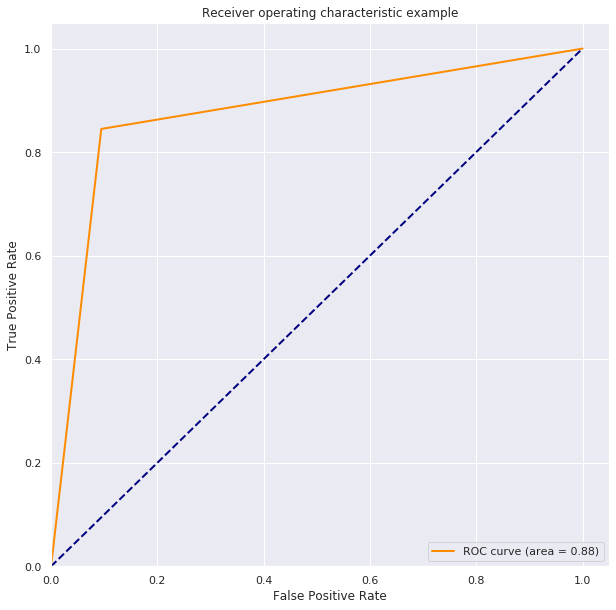

[[64734  6757]
 [  908  4942]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.94     71491
           1       0.42      0.84      0.56      5850

    accuracy                           0.90     77341
   macro avg       0.70      0.88      0.75     77341
weighted avg       0.94      0.90      0.92     77341



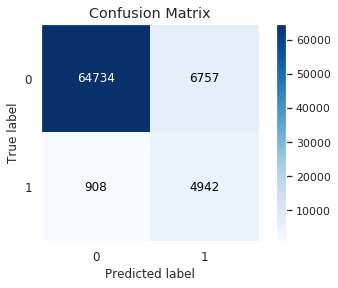

In [115]:
print('f1 score of test data',f1_score(y_test,y_test_ocs))
print('AUC value of test data',roc_auc_score(y_test,y_test_ocs))


print('f1 score of outliers data',f1_score(y_outliers,y_outliers_ocs))

 ###計算真正率和假正率
fpr,tpr,threshold = roc_curve(y_test, y_test_ocs) ###計算真正率和假正率
###計算auc的值
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
 ###假正率為橫座標，真正率為縱座標做曲線
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

skplt.metrics.plot_confusion_matrix(y_test, y_test_ocs)

cf = confusion_matrix(y_test,y_test_ocs)
print(cf)

cr = classification_report(y_test,y_test_ocs)
print(cr)

In [116]:
joblib.dump(ocs,'D:/karma5.0/model_file/41to60/OCS_third.pkl')

['D:/karma5.0/model_file/41to60/OCS_third.pkl']

# Supported Vector Classifier

In [7]:
smote = SMOTE()
y = df_ML['mb']
X = df_ML.drop(['mb'],axis=1)
X_res, y_res = smote.fit_resample(X,y)

X_train1,X_test1,y_train1,y_test1 = train_test_split(X_res,y_res,test_size = 0.2,random_state=32)
te = TargetEncoder(cols=['DuringMBA', 'RH', 'AH', 're', 'fbCNT',
       'nCR', 'nMR', 'nTR', 'nconcompla', 'nmatcompla','nteccompla', 
        'isIntCNT','ALL_RH', 'ALL_AH', 'ALL_re', 'ALL_fbCNT', 'ALL_nCR', 'ALL_nMR',
       'ALL_nTR', 'ALL_nconcompla', 'ALL_nmatcompla', 'ALL_nteccompla',
       'ALL_accLIKE', 'ALL_proLIKE', 'ALL_accDLIKE', 'ALL_proDLIKE',
       'ALL_FavorCNT', 'ALL_BlockCNT', 'ALL_AddFavorCNT', 'ALL_AddBlockCNT',
       'ALL_star', 'ALL_isIntCNT',
       'ALL_conUUCCNT','ALL_conSOUCNT', 'ALL_conSERCNT', 'ALL_conTWBCNT', 'ALL_conOTHCNT',
       'ALL_conLigCNT', 'ALL_conMedCNT', 'ALL_conTanCNT', 'ALL_conDarCNT',
       'ALL_conEx01CNT', 'ALL_conEx03CNT', 'ALL_conEx12CNT', 'ALL_conEx24CNT',
       'ALL_conage30CNT', 'ALL_conage40CNT', 'ALL_conage50CNT',
       'ALL_conage60CNT', 'ALL_conage61CNT', 'ALL_conMCNT', 'ALL_conFCNT',
       'ALL_helpCNT','ALL_help3mCNT',
        'mb_STV', 'mbaCNT',
       'MBA_total', 'mbadiff','mbaFtoSelltime', 'mbaNtoSelltime',
       'ALL_MGM_total','ALL_Like_total', 'ALL_DLike_total','ALL_help_total', 'ALL_help_max_total','ALL3m_help_max_total']).fit(X_res,y_res)

X_train_te1 = te.transform(X_train1)
X_test_te1 = te.transform(X_test1)
X_te1 = te.transform(X_res)

print(y_train1.shape)
print(y_test1.shape)
print(y_res.shape)


print(X_train_te1.shape)
print(X_test_te1.shape)
print(X_te1.shape)


(572076,)
(143020,)
(715096,)
(572076, 66)
(143020, 66)
(715096, 66)


In [8]:
SVC = svm.SVC(probability=True)
SVC.fit(X_train_te1,y_train1)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [9]:
y_test_predc1 = SVC.predict(X_test_te1)
y_test_predcPro1 = SVC.predict_proba(X_test_te1)

y_predc1 = SVC.predict(X_te1)
y_predcPro1 = SVC.predict_proba(X_te1)

#y_out_predc1 = SVC.predict(X_outliers_te1)
#y_out_predcPro1 = SVC.predict_proba(X_outliers_te1)

In [13]:
SVC_Class = classification_report(y_test1,y_test_predc1)
print(SVC_Class)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71573
           1       1.00      1.00      1.00     71447

    accuracy                           1.00    143020
   macro avg       1.00      1.00      1.00    143020
weighted avg       1.00      1.00      1.00    143020



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


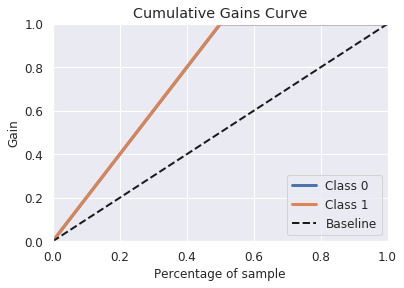

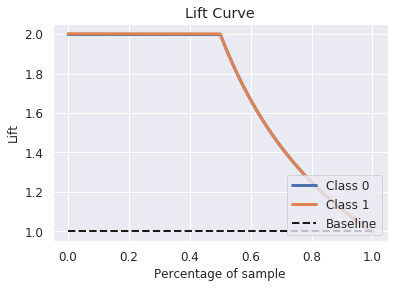

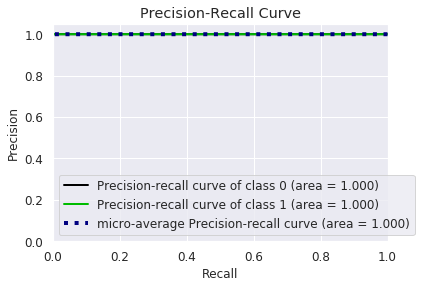

ValueError: Found input variables with inconsistent numbers of samples: [143020, 715096]

In [12]:
skplt.metrics.plot_cumulative_gain(y_test1, y_test_predcPro1)
plt.show()
skplt.metrics.plot_lift_curve(y_test1, y_test_predcPro1)
plt.show()
skplt.metrics.plot_precision_recall(y_test1, y_test_predcPro1)
plt.show()

fpr,tpr,threshold = roc_curve(y_test1, y_predc1) ###計算真正率和假正率
###計算auc的值
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
 ###假正率為橫座標，真正率為縱座標做曲線
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# LightGBM & CatBoosting

In [93]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier,Pool
from xgboost import XGBClassifier,XGBRFClassifier
from imblearn.over_sampling import SMOTE

In [90]:
smote = SMOTE()
y = df_ML['mb']
X = df_ML.drop(['mb'],axis=1)
X_res, y_res = smote.fit_resample(X,y)

X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size = 0.2,random_state=40)
te = TargetEncoder(cols=['DuringMBA', 'RH', 'AH', 're', 'fbCNT',
       'nCR', 'nMR', 'nTR', 'nconcompla', 'nmatcompla','nteccompla', 
        'isIntCNT','ALL_RH', 'ALL_AH', 'ALL_re', 'ALL_fbCNT', 'ALL_nCR', 'ALL_nMR',
       'ALL_nTR', 'ALL_nconcompla', 'ALL_nmatcompla', 'ALL_nteccompla',
       'ALL_accLIKE', 'ALL_proLIKE', 'ALL_accDLIKE', 'ALL_proDLIKE',
       'ALL_FavorCNT', 'ALL_BlockCNT', 'ALL_AddFavorCNT', 'ALL_AddBlockCNT',
       'ALL_star', 'ALL_isIntCNT',
       'ALL_conUUCCNT','ALL_conSOUCNT', 'ALL_conSERCNT', 'ALL_conTWBCNT', 'ALL_conOTHCNT',
       'ALL_conLigCNT', 'ALL_conMedCNT', 'ALL_conTanCNT', 'ALL_conDarCNT',
       'ALL_conEx01CNT', 'ALL_conEx03CNT', 'ALL_conEx12CNT', 'ALL_conEx24CNT',
       'ALL_conage30CNT', 'ALL_conage40CNT', 'ALL_conage50CNT',
       'ALL_conage60CNT', 'ALL_conage61CNT', 'ALL_conMCNT', 'ALL_conFCNT',
       'ALL_helpCNT','ALL_help3mCNT',
        'mb_STV', 'mbaCNT',
       'MBA_total', 'mbadiff','mbaFtoSelltime', 'mbaNtoSelltime',
       'ALL_MGM_total','ALL_Like_total', 'ALL_DLike_total','ALL_help_total', 'ALL_help_max_total','ALL3m_help_max_total']).fit(X_res,y_res)

In [91]:
X_train_te = te.transform(X_train)
X_test_te = te.transform(X_test)
X_te = te.transform(X_res)

print(y_train.shape)
print(y_test.shape)
print(y.shape)
print(y_outliers.shape)

print(X_train_te.shape)
print(X_test_te.shape)
print(X_te.shape)
print(X_outliers.shape)

(572076,)
(143020,)
(386703,)
(29155,)
(572076, 66)
(143020, 66)
(715096, 66)
(29155, 66)


## LightGBM Classifier

In [92]:
GBM = LGBMClassifier()
GBM.fit(X_train_te,y_train)

y_pre = GBM.predict(X_test_te)
y_pre_pro = GBM.predict_proba(X_test_te)

y_total_pre = GBM.predict(X_te)
y_total_pre_pro = GBM.predict(X_te)

GMB_Class = classification_report(y_test,y_pre)
print(GMB_Class)

GMB_Class_total = classification_report(y_res,y_total_pre)
print(GMB_Class_total)

#joblib.dump(GBM,'D:/karma5.0/model_file/test/GMB_test.pkl')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71527
           1       1.00      1.00      1.00     71493

    accuracy                           1.00    143020
   macro avg       1.00      1.00      1.00    143020
weighted avg       1.00      1.00      1.00    143020

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    357548
           1       1.00      1.00      1.00    357548

    accuracy                           1.00    715096
   macro avg       1.00      1.00      1.00    715096
weighted avg       1.00      1.00      1.00    715096



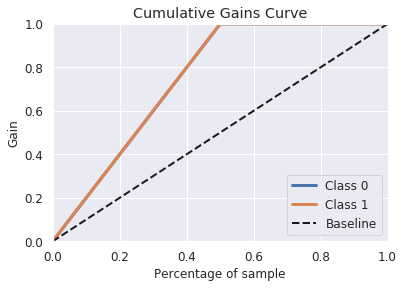

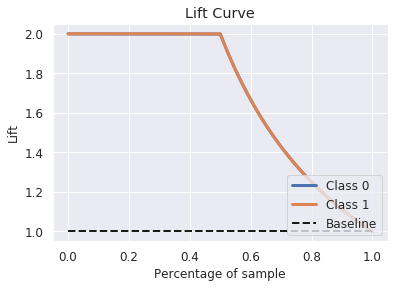

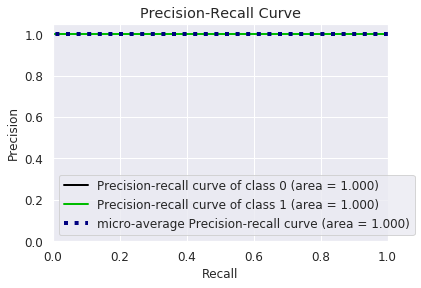

<Figure size 432x288 with 0 Axes>

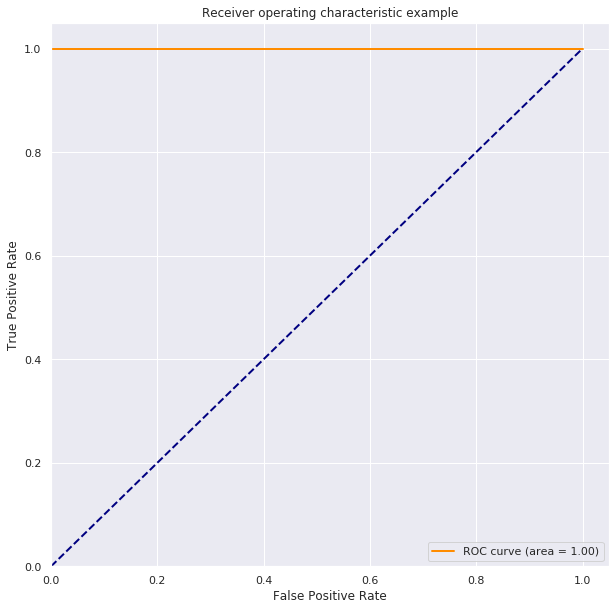

In [102]:
skplt.metrics.plot_cumulative_gain(y_test, y_pre_pro)
plt.show()
skplt.metrics.plot_lift_curve(y_test, y_pre_pro)
plt.show()
skplt.metrics.plot_precision_recall(y_test, y_pre_pro)
plt.show()

fpr,tpr,threshold = roc_curve(y_test, y_pre) ###計算真正率和假正率
###計算auc的值
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
 ###假正率為橫座標，真正率為縱座標做曲線
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## CatBoost Classifier

In [107]:
CBC = CatBoostClassifier(iterations=10,depth=16,learning_rate=0.1,loss_function='Logloss',verbose=False)
catboost_pool = Pool(X_train_te,y_train)

CBC.fit(X_train_te,y_train)
y_pre = CBC.predict(X_test_te)
y_pre_pro = CBC.predict_proba(X_test_te)

y_total_pre = CBC.predict(X_te)
y_total_pre_pro = CBC.predict_proba(X_te)

CBC_CR = classification_report(y_test,y_pre)
print(CBC_CR)
CBC_Class_total = classification_report(y_res,y_total_pre)
print(CBC_Class_total)


y_pre1 = CBC.predict(catboost_pool)
y_pre_pro1 = CBC.predict_proba(catboost_pool)
CBC_Class = classification_report(y_train,y_pre1)
print(CBC_Class)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71527
           1       1.00      1.00      1.00     71493

    accuracy                           1.00    143020
   macro avg       1.00      1.00      1.00    143020
weighted avg       1.00      1.00      1.00    143020

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    357548
           1       1.00      1.00      1.00    357548

    accuracy                           1.00    715096
   macro avg       1.00      1.00      1.00    715096
weighted avg       1.00      1.00      1.00    715096

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286021
           1       1.00      1.00      1.00    286055

    accuracy                           1.00    572076
   macro avg       1.00      1.00      1.00    572076
weighted avg       1.00      1.00      1.00    572076



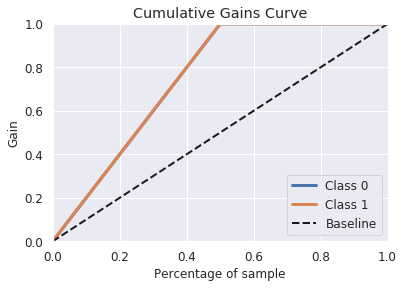

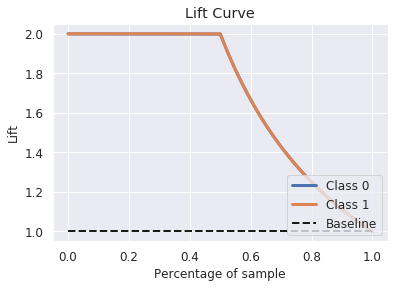

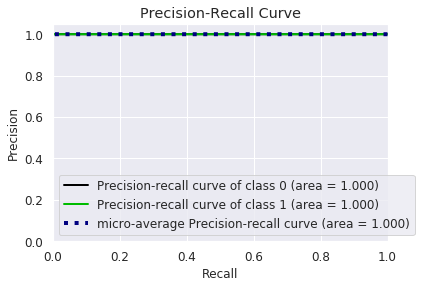

<Figure size 432x288 with 0 Axes>

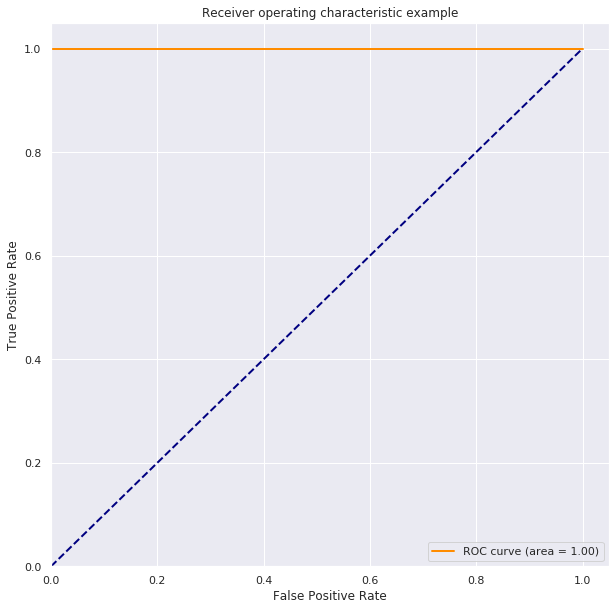

In [108]:
skplt.metrics.plot_cumulative_gain(y_test, y_pre_pro)
plt.show()
skplt.metrics.plot_lift_curve(y_test, y_pre_pro)
plt.show()
skplt.metrics.plot_precision_recall(y_test, y_pre_pro)
plt.show()

fpr,tpr,threshold = roc_curve(y_test, y_pre) ###計算真正率和假正率
###計算auc的值
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
 ###假正率為橫座標，真正率為縱座標做曲線
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()